In [ ]:
import pickle
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

import time
import datetime

print(datetime.datetime.now())

In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
fn_predictionsTraining  = path_data + 'predictionsTraining_binary_s20230504.xlsx'
fn_predictionsValidation = path_data + 'predictionsValidation_binary_s20230508.xlsx'
fn_patient = '../metadata/Celine_FINAL_RADIOPOP_DATA_with LRE Death_220729.xlsx'

# OUTPUTS
fn_f_survivalCurve_cACLD = '../figures/f_survivalCurvecACLD_s20230516.png'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [4]:
predictions_train = pd.read_excel(fn_predictionsTraining, index_col=0)
predictions_validations = pd.read_excel(fn_predictionsValidation, index_col=0)
predictions_binary = pd.concat([predictions_train, predictions_validations])
predictions_binary['id'] = predictions_binary.index
predictions_binary['id'] = predictions_binary['id'].apply(lambda x: str(x).zfill(4))
predictions_binary = predictions_binary.set_index('id')

In [ ]:
currMeta = dict_data['df_metadata']
currMeta = currMeta.dropna()

# cACLD analysis: keep only cACLD patients
currMeta = currMeta[currMeta['decompensated_acld'] == '1']
# cACLD analysis: censor for not liver related death
currMeta['censor_lrd'] = currMeta.apply(lambda row: False if (row.survival_tf == False and row.lrd_tf == False) else True, axis = 1)

# make variables
temp = pd.get_dummies(currMeta['meld_grp'], prefix='meldgrp')
currMeta = pd.concat([currMeta, temp], axis = 1)
temp = pd.get_dummies(currMeta['cps_grp'], prefix='cpsgrp')
currMeta = pd.concat([currMeta, temp], axis = 1)

currMeta['etio_alcLiverDisease'] = currMeta['etiology'].apply(lambda x: True if x == '1' else False)
currMeta['etio_nonAlcFattyLiver'] = currMeta['etiology'].apply(lambda x: True if x == '2' else False)
currMeta['etio_viral'] = currMeta['etiology'].apply(lambda x: True if x == '3' else False)
currMeta['etio_other'] = currMeta['etiology'].apply(lambda x: True if x == '4' else False)
currMeta['etio_unknown'] = currMeta['etiology'].apply(lambda x: True if x == '5' else False)

# create composite endpoint: lre OR lrd
currMeta['lre_or_lrd_tf'] = (~currMeta['decompBL'].astype(bool)) | (currMeta['lrd_tf']) # what celine thinks is correct
# #currMeta['lre_or_lrd_tf'] = (currMeta['decompBL'].astype(bool)) | (currMeta['lrd_tf'])
currMeta['lre_or_lrd'] = currMeta[['lre','lrd']].min(axis=1)

# add radipop predictions
currMeta = currMeta.merge(predictions_binary[['pred_bin']], how='inner', left_index=True, right_index=True)

currMeta

In [6]:
print(np.where((currMeta['lre'] != currMeta['lre_or_lrd'])))
print(np.where((currMeta['lre'] > currMeta['lrd'])))

(array([ 17, 118]),)
(array([ 17, 118]),)


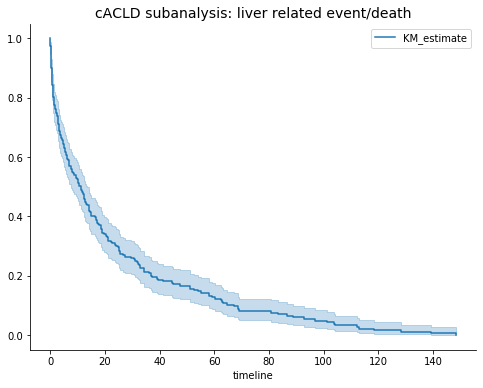

In [7]:
# km curve for Event=decompensation/death, Censoring: non-liver related death
time = currMeta['lre']
censoring = currMeta['censor_lrd']

kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = censoring)

fig, ax = plt.subplots(figsize=(8, 6))
kmf.plot_survival_function()
plt.title('cACLD subanalysis: liver related event/death')

plt.savefig(fn_f_survivalCurve_cACLD)

In [8]:
print(datetime.datetime.now())

2023-07-26 07:27:44.613991
